In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Setup

In [5]:
import re, shutil
from glob import glob
import tqdm
import matplotlib.pylab as plt
 
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, losses

In [6]:
#try:
#    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#    print('Device:', tpu.master())
#    tf.config.experimental_connect_to_cluster(tpu)
#    tf.tpu.experimental.initialize_tpu_system(tpu)
#    strategy = tf.distribute.experimental.TPUStrategy(tpu)
#except:
#    strategy = tf.distribute.get_strategy()
#print('Number of replicas:', strategy.num_replicas_in_sync)


img_shape = [256, 256, 3]

print(tf.__version__)

2.15.0


# Load the dataset

In [7]:
def load_dataset(filenames, labeled=True, ordered=False, autotune=tf.data.experimental.AUTOTUNE):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autotune)
    return dataset
 
def decode_image(image, img_size=[256,256,3]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1       
    image = tf.reshape(image, img_size)             
    return image
 
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image":      tf.io.FixedLenFeature([], tf.string),
        "target":     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)  
    image = decode_image(example['image'])    
    return image
 
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
 
data_path = '/kaggle/input/gan-getting-started'
monet_filenames = tf.io.gfile.glob(str(os.path.join(data_path, 'monet_tfrec', '*.tfrec')))
photo_filenames = tf.io.gfile.glob(str(os.path.join(data_path, 'photo_tfrec', '*.tfrec')))
 
monet_ds = load_dataset(monet_filenames)
photo_ds = load_dataset(photo_filenames)
 
n_monet_samples = count_data_items(monet_filenames)
n_photo_samples = count_data_items(photo_filenames)
dataset = tf.data.Dataset.zip((monet_ds, photo_ds))
 
n_monet_samples, n_photo_samples


(300, 7038)

# Plot the images

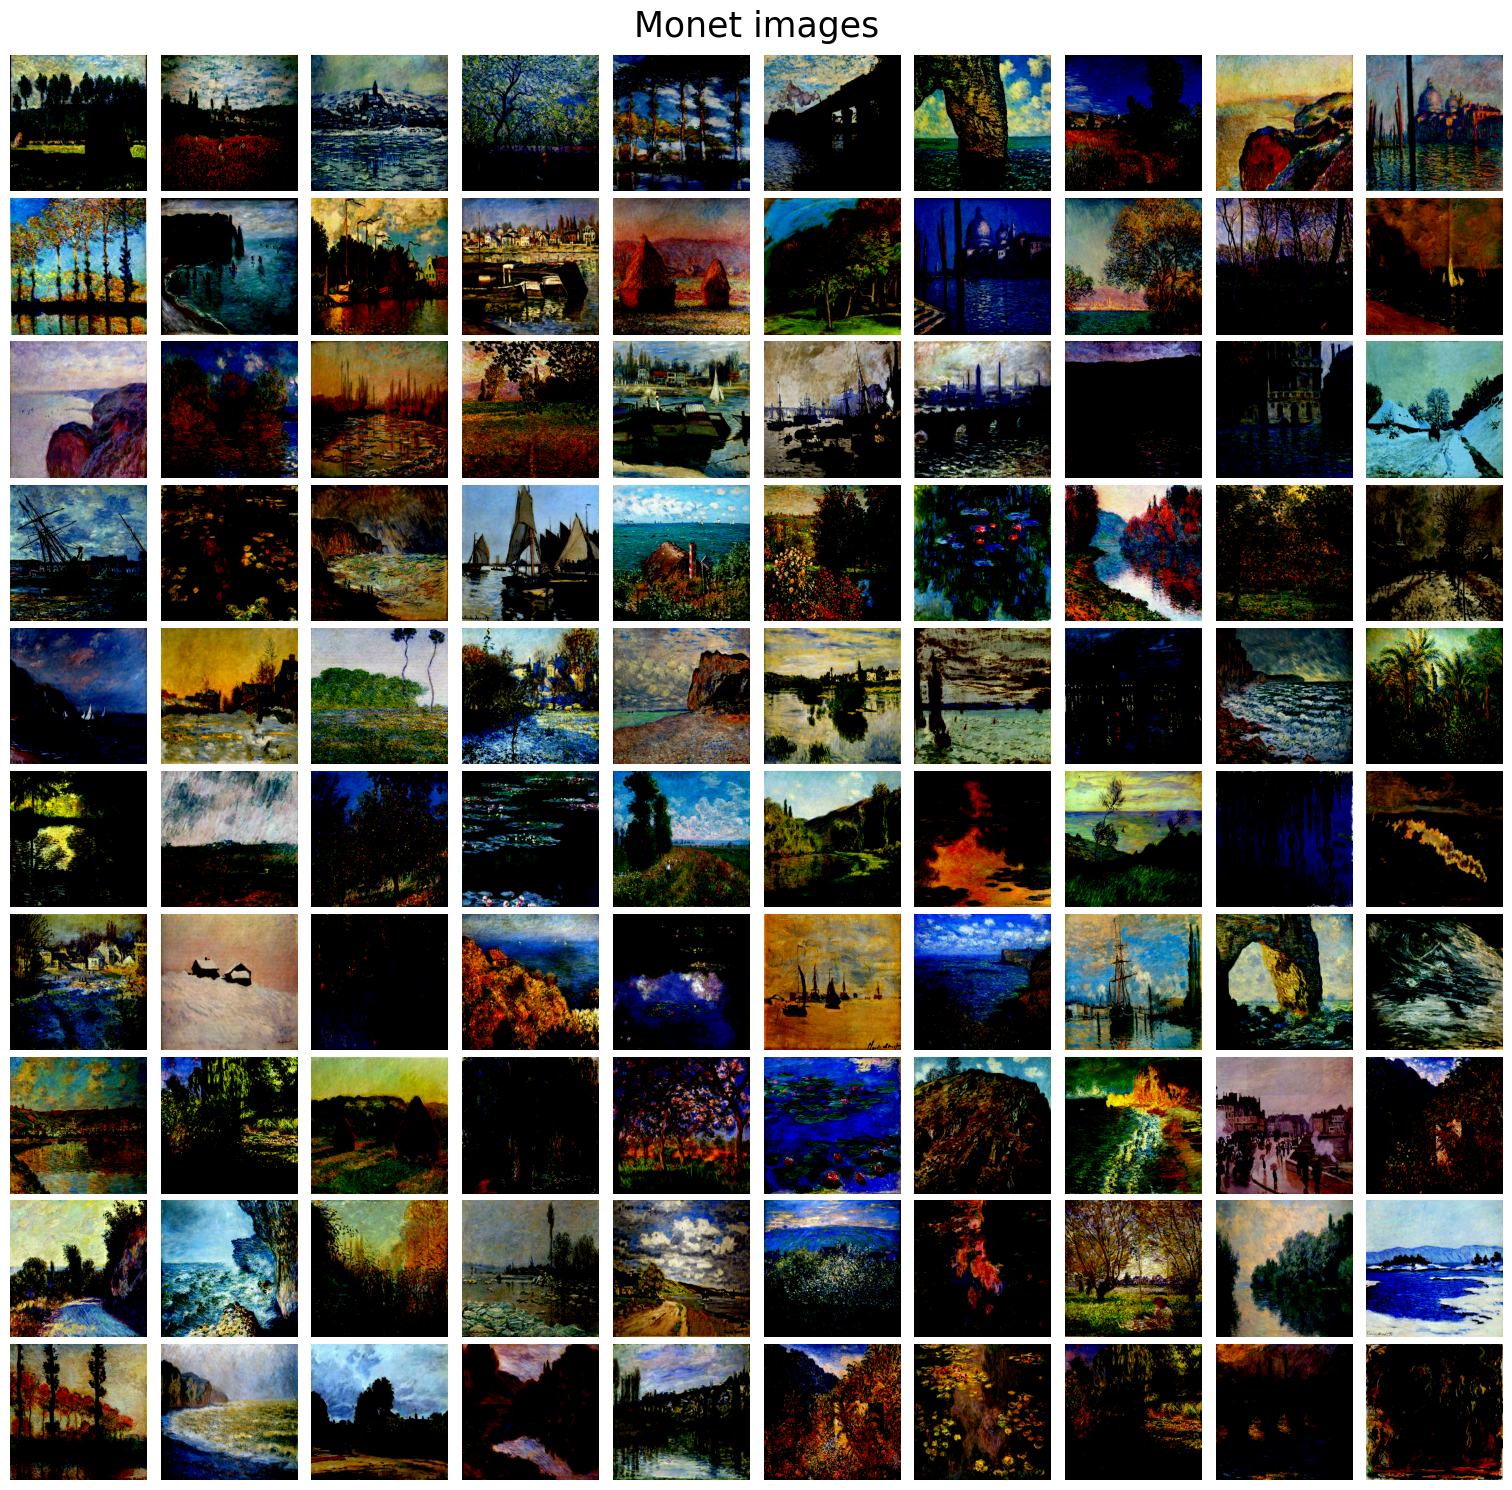

In [8]:
def plot_images(images, title):
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
    j = 1
    for i in np.random.choice(len(images), 100, replace=False):
        plt.subplot(10,10,j), plt.imshow(images[i] / images[i].max()), plt.axis('off')
        j += 1
    plt.suptitle(title, size=25)
    plt.show()

monet_numpy = list(monet_ds.as_numpy_iterator())
plot_images(monet_numpy, 'Monet images')

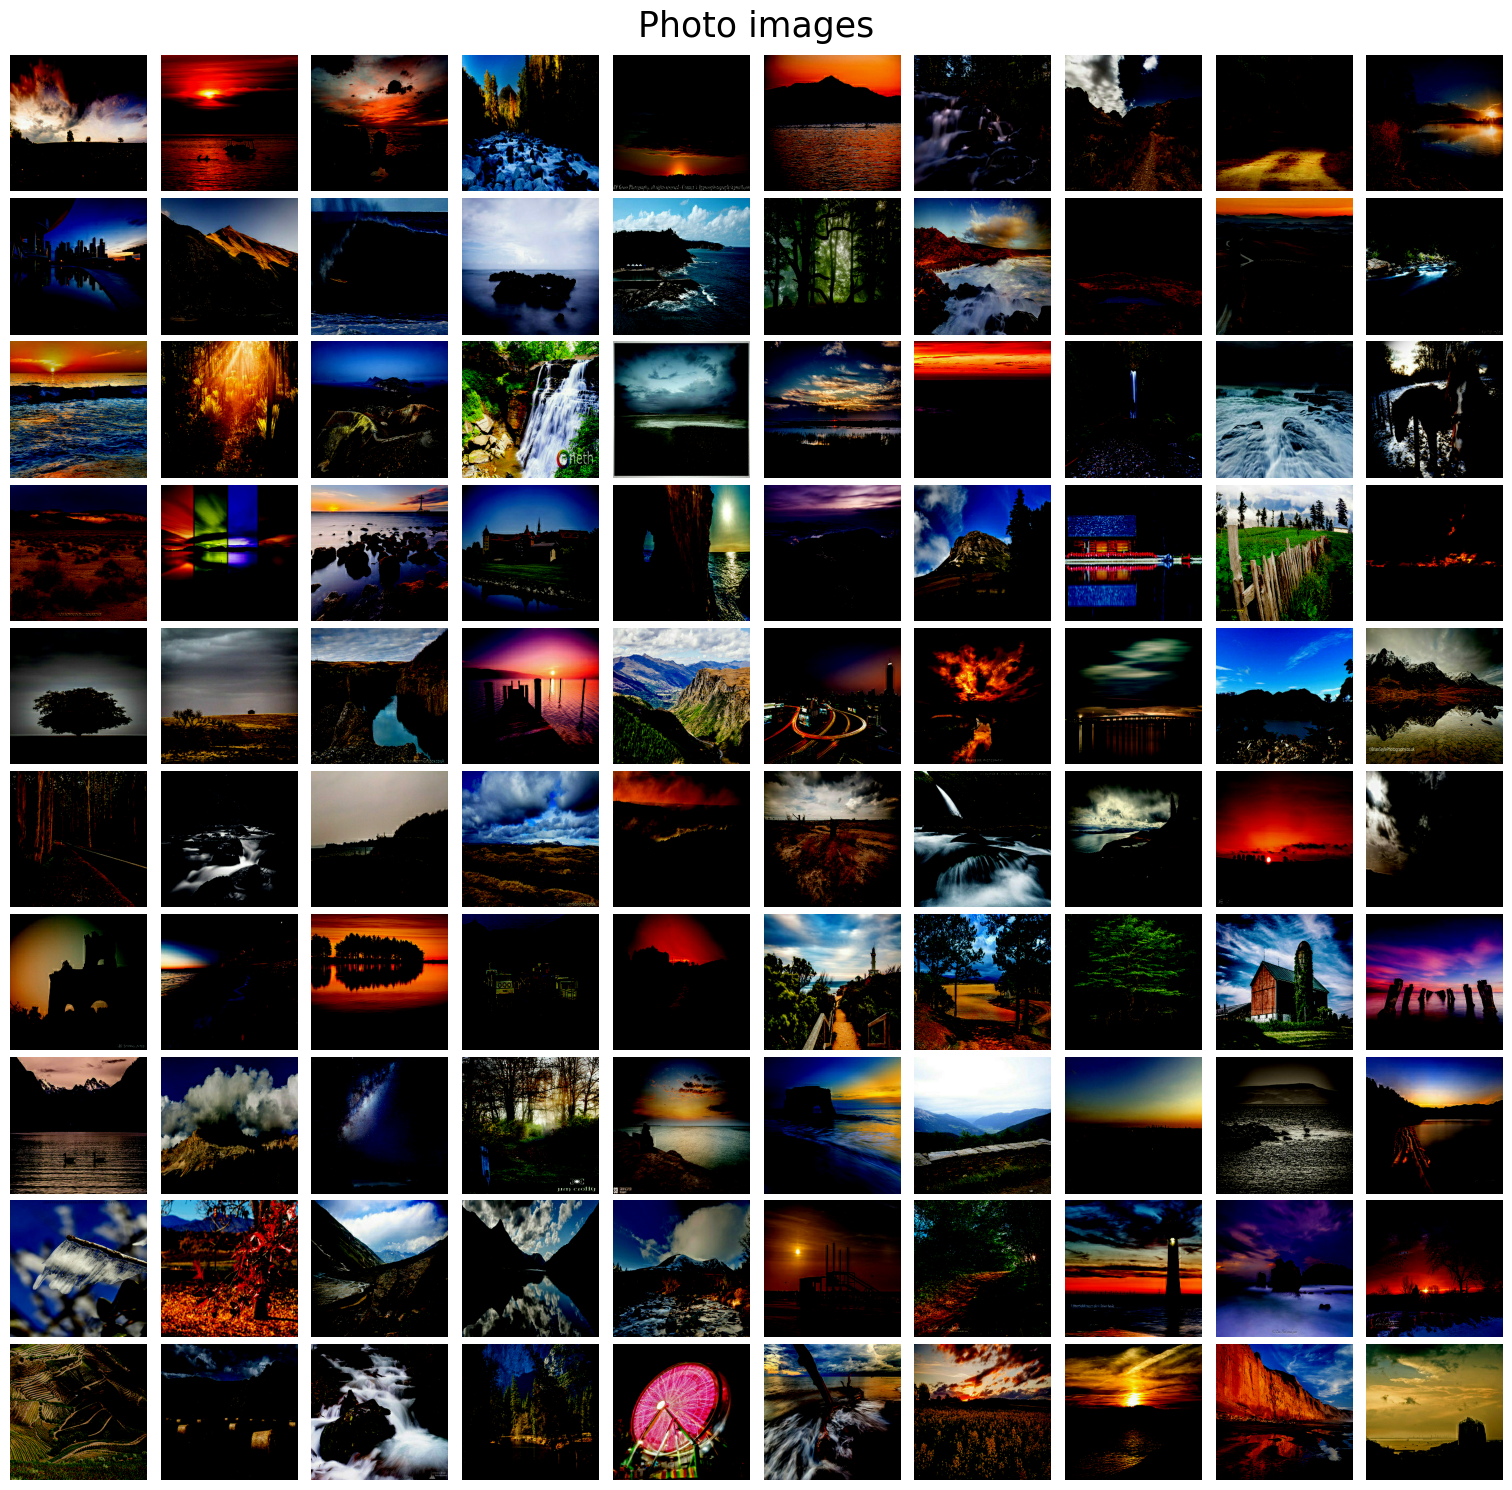

In [9]:
plot_images(list(photo_ds.as_numpy_iterator()), 'Photo images')

# Define a CycleGAN Model

In [10]:
class CycleGAN(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
         
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
    ):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
 
    def generate(self, image):
        return self.m_gen(tf.expand_dims(image, axis=0), training=False)
 
    def load(
        self, 
        filepath
    ):
        self.m_gen.load_weights(filepath.replace('model_name', 'm_gen'), by_name=True)
        self.p_gen.load_weights(filepath.replace('model_name', 'p_gen'), by_name=True)
        self.m_disc.load_weights(filepath.replace('model_name', 'm_disc'), by_name=True)
        self.p_disc.load_weights(filepath.replace('model_name', 'p_disc'), by_name=True)
 
    def save(
        self, 
        filepath
    ):
        self.m_gen.save(filepath.replace('model_name', 'm_gen'))
        self.p_gen.save(filepath.replace('model_name', 'p_gen'))
        self.m_disc.save(filepath.replace('model_name', 'm_disc'))
        self.p_disc.save(filepath.replace('model_name', 'p_disc'))
 
         
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
         
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            real_photo = tf.expand_dims(real_photo, axis=0)
            real_monet = tf.expand_dims(real_monet, axis=0)
 
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
 
            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
 
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
 
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
 
            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
 
            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
 
            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
 
            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
 
            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
 
        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
 
        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
         
        total_loss = total_monet_gen_loss + total_photo_gen_loss + monet_disc_loss + photo_disc_loss
 
        return {
            "total_loss": total_loss,
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define a Generator and Discriminator

In [14]:
def Generator(img_shape=img_shape):
    inputs = layers.Input(shape=img_shape)
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
 
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
 
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
 
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)
    return keras.Model(inputs=inputs, outputs=x)
 
def Discriminator(img_shape=img_shape):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
 
    inp = layers.Input(shape=img_shape, name='input_image')
    x = inp
 
    x = downsample(64, 4, False)(x) 
    x = downsample(128, 4)(x) 
    x = downsample(256, 4)(x) 
 
    x = layers.ZeroPadding2D()(x) 
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x) 
    x = layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x) 
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x) 
 
    return tf.keras.Model(inputs=inp, outputs=x)

In [15]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
 
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())
    return result
 
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result
 
def discriminator_loss(real, generated):
    real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5
     
def generator_loss(generated):
    return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
         
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))
 
def identity_loss(real_image, same_image, LAMBDA):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

In [16]:
monet_generator = Generator(img_shape) # transforms photos to Monet-esque paintings
photo_generator = Generator(img_shape) # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator(img_shape) # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator(img_shape) # differentiates real photos and generated photos


# Build the model

In [17]:
model = CycleGAN(
    monet_generator=monet_generator,
    photo_generator=photo_generator,
    monet_discriminator=monet_discriminator,
    photo_discriminator=photo_discriminator,
)
 
model.compile(
    m_gen_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    p_gen_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    m_disc_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    p_disc_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss,
)

In [18]:
model.summary()

Model: "cycle_gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_16 (Functional)      │ ?                      │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_33 (Functional)      │ ?                      │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_38 (Functional)      │ ?                      │     2,765,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_43 (Functional)      │ ?                      │     2,765,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,361,096 (436.25 MB)

 Trainable params: 114,361,096 (436.25 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [19]:
# Train the model
epochs = 50
history = model.fit(dataset, epochs=epochs)


Epoch 1/50


I0000 00:00:1713121905.473267      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 138s 147ms/step - monet_disc_loss: 0.5724 - monet_gen_loss: 6.2501 - photo_disc_loss: 0.5419 - photo_gen_loss: 6.4210 - total_loss: 13.7855 - loss: 0.0000e+00
Epoch 2/50
  1/300 ━━━━━━━━━━━━━━━━━━━━ 52s 175ms/step - monet_disc_loss: 0.7350 - monet_gen_loss: 4.4212 - photo_disc_loss: 0.4914 - photo_gen_loss: 4.6913 - total_loss: 10.3389

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 4.4196 - photo_disc_loss: 0.4938 - photo_gen_loss: 4.6134 - total_loss: 10.1482 - loss: 0.0000e+00
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - monet_disc_loss: 0.6703 - monet_gen_loss: 3.8726 - photo_disc_loss: 0.4067 - photo_gen_loss: 4.4585 - total_loss: 9.4081 - loss: 0.0000e+00
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - monet_disc_loss: 0.6226 - monet_gen_loss: 3.8049 - photo_disc_loss: 0.4197 - photo_gen_loss: 4.4190 - total_loss: 9.2662 - loss: 0.0000e+00
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - monet_disc_loss: 0.5547 - monet_gen_loss: 3.9172 - photo_disc_loss: 0.4937 - photo_gen_loss: 4.2874 - total_loss: 9.2531 - loss: 0.0000e+00
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - monet_disc_loss: 0.5434 - monet_gen_loss: 3.9404 - photo_disc_loss: 0.5281 - photo_gen_loss: 4.1559 - total_loss: 9.1678 - loss: 0.0000e+00
Epoch 7/50
300/300 ━━━━━━

# Generate images and submit results

In [20]:
! mkdir ../images
 
def generate(dataset):
    dataset_iter = iter(dataset)
    out_dir = '../images/'
    for i in tqdm.tqdm(range(n_photo_samples)):
        # Get the image from the dataset iterator
        img = next(dataset_iter)
        prediction = model.generate(img)
        prediction = tf.squeeze(prediction).numpy() 
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   
        plt.imsave(os.path.join(out_dir, 'image_{:04d}.jpg'.format(i)), prediction)

generate(photo_ds)
 
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

100%|██████████| 7038/7038 [07:58<00:00, 14.70it/s]


'/kaggle/working/images.zip'

# Compare images

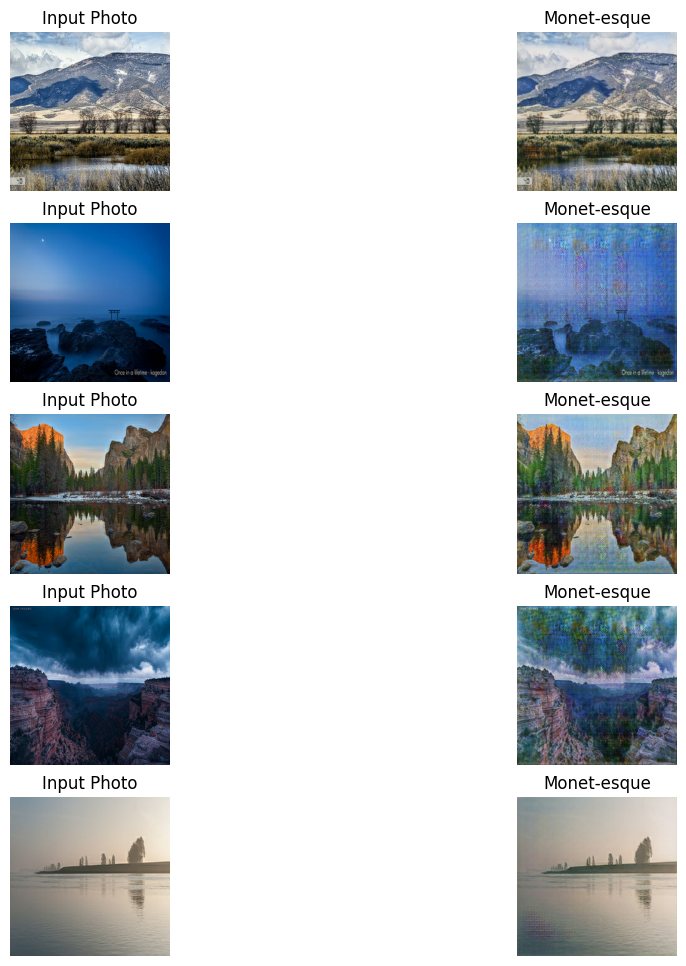

In [21]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = model.generate(img)
    prediction = tf.squeeze(prediction).numpy() 
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   
    img = (img * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()
